In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.misc import imread

In [2]:
def add_gaussian_noise(im,prop,varSigma):
    N = int(np.round(np.prod(im.shape)*prop))
    index = np.unravel_index(np.random.permutation(np.prod(im.shape))[1:N],im.shape)
    e = varSigma*np.random.randn(np.prod(im.shape)).reshape(im.shape)
    im2 = np.copy(im)
    im2[index] += e[index]
    return im2
def add_saltnpeppar_noise(im,prop):
    N = int(np.round(np.prod(im.shape)*prop))
    index = np.unravel_index(np.random.permutation(np.prod(im.shape))[1:N],im.shape)
    im2 = np.copy(im)
    im2[index] = 1-im2[index]
    return im2

In [3]:
# MxN are Image dimensions 
# i and j is co-ordiantes of node being evaluated
# n is nearest neighbours


def neighbours(i,j,M,N,size=8):
    if size==4:
        if (i==0 and j==0):
            n=[(0,1), (1,0)]
        elif i==0 and j==N-1:
            n=[(0,N-2), (1,N-1)]
        elif i==M-1 and j==0:
            n=[(M-1,1), (M-2,0)]
        elif i==M-1 and j==N-1:
            n=[(M-1,N-2), (M-2,N-1)]
        elif i==0:
            n=[(0,j-1), (0,j+1), (1,j)]
        elif i==M-1:
            n=[(M-1,j-1), (M-1,j+1), (M-2,j)]
        elif j==0:
            n=[(i-1,0), (i+1,0), (i,1)]
        elif j==N-1:
            n=[(i-1,N-1), (i+1,N-1), (i,N-2)]
        else:
            n=[(i-1,j), (i+1,j), (i,j-1), (i,j+1)]
        return n
    if size==8:
        if (i==0 and j==0):
            n=[(0,1),(1,1), (1,0)]
        elif i==0 and j==N-1:
            n=[(0,N-2),(1,N-2), (1,N-1)]
        elif i==M-1 and j==0:
            n=[(M-1,1),(M-2,1), (M-2,0)]
        elif i==M-1 and j==N-1:
            n=[(M-1,N-2),(M-2,N-2), (M-2,N-1)]
        elif i==0:
            n=[(0,j-1), (0,j+1), (1,j), (1,j-1), (1,j+1)]
        elif i==M-1:
            n=[(M-1,j-1), (M-1,j+1), (M-2,j), (M-2,j-1), (M-2,j+1)]
        elif j==0:
            n=[(i-1,0), (i+1,0), (i,1), (i-1,1), (i+1,1)]
        elif j==N-1:
            n=[(i-1,N-1), (i+1,N-1), (i,N-2), (i-1,N-2), (i+1,N-2)]
        else:
            n=[(i-1,j), (i+1,j), (i,j-1), (i,j+1), (i-1,j-1), (i-1,j+1), (i+1,j+1), (i+1,j-1)]
        return n
    return -1

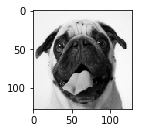

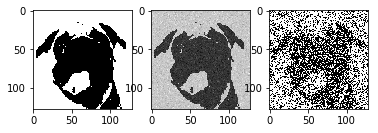

In [83]:
# proportion of pixels to alter

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

def convertToBinary(im):
    for i in range(im.shape[0]):
        for j in range(im.shape[1]):
            if(im[i][j] >0.5):
                im[i][j] = 1
            else:
                im[i][j] = 0
    return im

prop = 0.7
prop2 = 0.3
varSigma = 0.1
im = rgb2gray(imread('pug128x128.png'))



im = im/255
fig = plt.figure()
ax = fig.add_subplot(131)
ax.imshow(im,cmap='gray')

im = convertToBinary(im)
fig = plt.figure()
ax = fig.add_subplot(131)
ax.imshow(im,cmap='gray')

im2 = add_gaussian_noise(im,prop,varSigma)
im2 = (im2 - im2.min())/(im2.max() - im2.min()) #normalising image
ax2 = fig.add_subplot(132)
ax2.imshow(im2,cmap='gray')


im3 = add_saltnpeppar_noise(im,prop2)
im3 = (im3 - im3.min())/(im3.max() - im3.min())
ax3 = fig.add_subplot(133)
ax3.imshow(im3,cmap='gray')

plt.show()

Found minimum early: 1


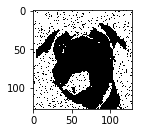

In [84]:
# Iteratuve Conditional Modes
M, N = im2.shape

def prob(im,  i, j, h, beta, eta):
    n = neighbours(i,j, M,N, size=8)
    sumPlus = 0 
    sumMinus = 0
    for k in range(np.shape(n)[0]):
        sumPlus += im[n[k]] * 1
        sumMinus -= im[n[k]] * -1
    val1 = np.exp(-(h*1 - beta * sumPlus - eta*1*im[i][j]))
    val2 = np.exp(-(h*-1 - beta * sumMinus - eta*-1*im[i][j]))
    return val1>val2

def denoise_ICM(im, h, beta, eta, iterations):
    x = im.copy()
    for count in range(iterations):
        countChange = 0
        for i in  range(im.shape[0]):
            for j in range(im.shape[1]):
                if(prob(im,i,j,h,beta,eta)):
                    x[i][j] = 1
                    if(im[i][j] != 1):
                        countChange += 1
                else:
                    x[i][j] = -1
                    if(im[i][j] != -1):
                        countChange += 1
        if (countChange == 0): 
            print("Found minimum early: " + str(count))
            return x
        im = x.copy()
    print(iterations)
    return x


imICM = denoise_ICM(im2, 0.5, 0.4, 0.7, 30)
imICM = (imICM + 1)/2
fig = plt.figure()
ax2 = fig.add_subplot(131)
ax2.imshow(imICM,cmap='gray')

plt.show()
